<a href="https://colab.research.google.com/github/YDj-robot/Polish-companies-bankruptcy-data/blob/main/polish_companies_bankruptcy_data_decision_tree_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Polish companies bankruptcy data
The dataset is about bankruptcy prediction of Polish companies.The bankrupt companies were analyzed in the period 2000-2012, while the still operating companies were evaluated from 2007 to 2013.
- 1stYear the data contains financial rates from 1st year of the forecasting period and corresponding class label that indicates bankruptcy status after 5 years. The data contains 7027 instances (financial statements), 271 represents bankrupted companies, 6756 firms that did not bankrupt in the forecasting period.

In [2]:
#!pip install kaggle

import os
import json
import zipfile
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.io import arff
from google.colab import files
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

In [3]:
# Upload Kaggle JSON file
uploaded = files.upload()

# Set Kaggle API credentials
kaggle_json = json.loads(uploaded['kaggle.json'].decode('utf-8'))
os.environ['KAGGLE_USERNAME'] = kaggle_json['username']
os.environ['KAGGLE_KEY'] = kaggle_json['key']

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d squintrook/forecasting-bankrupts-with-ann

  0% 0.00/8.55M [00:00<?, ?B/s]
100% 8.55M/8.55M [00:00<00:00, 96.1MB/s]


##1- Prepare Data

In [5]:
def wrangle(zip_file_path):

  # Create folder to extract the data
  extracted_dir = "data_folder"
  os.makedirs(extracted_dir, exist_ok=True)

  # Extract the zip file and load the first file to data frame
  with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(path=extracted_dir)
    all_files = zip_ref.namelist()
    first_file = extracted_dir + "/" + all_files[0]
    data, meta = arff.loadarff(first_file)
    df = pd.DataFrame(data)

  return df

###1.1- Import Data



In [39]:
df = wrangle("/content/forecasting-bankrupts-with-ann.zip")
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


###1.2- Explore Data


In [40]:
print("Shape: ", df.shape)

Shape:  (7027, 65)


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7027 entries, 0 to 7026
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Attr1   7024 non-null   float64
 1   Attr2   7024 non-null   float64
 2   Attr3   7024 non-null   float64
 3   Attr4   6997 non-null   float64
 4   Attr5   7019 non-null   float64
 5   Attr6   7024 non-null   float64
 6   Attr7   7024 non-null   float64
 7   Attr8   7002 non-null   float64
 8   Attr9   7026 non-null   float64
 9   Attr10  7024 non-null   float64
 10  Attr11  6988 non-null   float64
 11  Attr12  6997 non-null   float64
 12  Attr13  7027 non-null   float64
 13  Attr14  7024 non-null   float64
 14  Attr15  7025 non-null   float64
 15  Attr16  7002 non-null   float64
 16  Attr17  7002 non-null   float64
 17  Attr18  7024 non-null   float64
 18  Attr19  7027 non-null   float64
 19  Attr20  7027 non-null   float64
 20  Attr21  5405 non-null   float64
 21  Attr22  7024 non-null   float64
 22  

In [42]:
mapping = {b'0': False, b'1': True}  # Customize for your needs
df["class"] = df["class"].map(mapping)

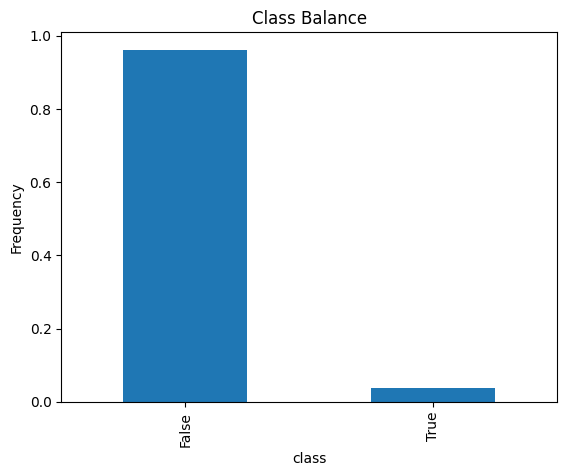

In [43]:
df["class"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="class",
    ylabel="Frequency",
    title="Class Balance"
);

**Attr27 (profit on operating activities / financial expenses)**
<br>
The ratio of Profit on Operating Activities to Financial Expenses is a financial metric that evaluates a company's ability to cover its financial expenses with the profit generated from its core operating activities. It provides insight into how well a company's operating profit supports its financial obligations such as interest payments.
<br>

*  A higher ratio suggests that the profit from operating activities is more than sufficient to cover financial expenses, indicating good financial health and the ability to meet debt obligations.
*   On the other hand, a lower ratio may signal potential challenges in meeting financial obligations through operating profits alone.

<br>
It's important to note that the interpretation of this ratio can vary across industries, and it is often used in conjunction with other financial ratios and metrics for a more comprehensive analysis of a company's financial performance and risk.

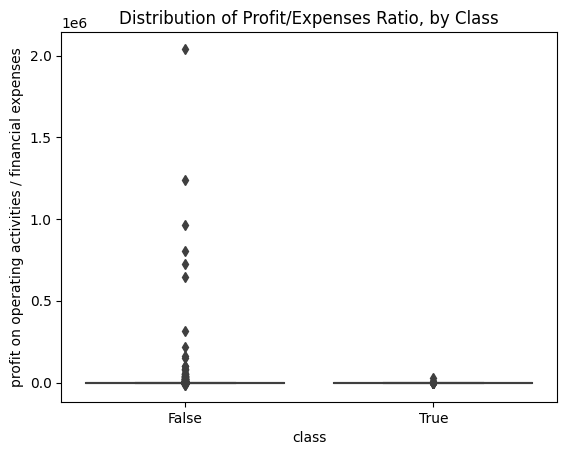

In [44]:
sns.boxplot(x="class", y="Attr27", data=df)
plt.xlabel("class")
plt.ylabel("profit on operating activities / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Class");

In [45]:
# Summary statistics for `Attr27`
df["Attr27"].describe().apply("{0:,.0f}".format)

count        6,716
mean         1,322
std         35,504
min        -14,790
25%              0
50%              1
75%              6
max      2,040,800
Name: Attr27, dtype: object

The median is around 1, but the mean is over 1000. That suggests that this feature is skewed to the right. Let's make a histogram to see what the distribution actually looks like.

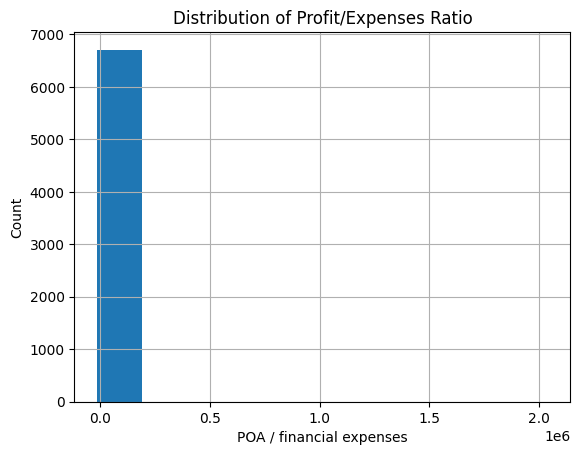

In [46]:
df["Attr27"].hist()
plt.xlabel("POA / financial expenses")
plt.ylabel("Count"),
plt.title("Distribution of Profit/Expenses Ratio");

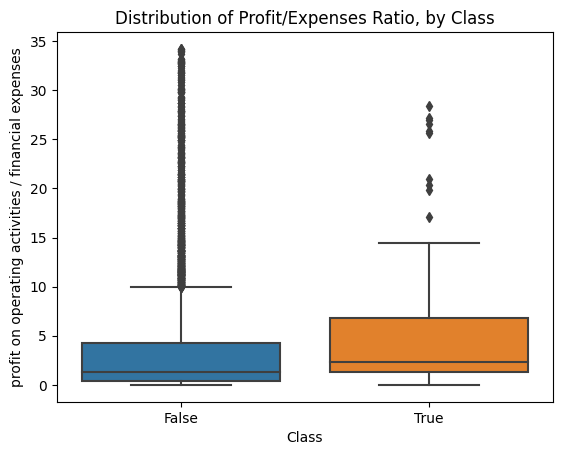

In [47]:
# Create clipped boxplot
q1, q9 = df["Attr27"].quantile([0.1, 0.9])
mask = df["Attr27"].between(q1, q9)
sns.boxplot(x="class", y="Attr27", data=df[mask])
plt.xlabel("Class")
plt.ylabel("profit on operating activities / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Class");

***Attr7 (EBIT / total assets)***
<br>The ratio EBIT (Earnings Before Interest and Taxes) to Total Assets is a financial metric that assesses a company's operational profitability in relation to its total assets. It is a measure of how efficiently a company generates earnings from its assets before considering interest and taxes.<br>
The formula for the EBIT/Total Assets ratio is:
<br>
\begin{equation}
\text{EBIT/Total Assets} = \frac{\text{EBIT}}{\text{Total Assets}}
\end{equation}

where:

*   EBIT is the Earnings Before Interest and Taxes, which represents a company's operating profit.
*   Total Assets refer to the sum of all assets owned or used by the company.

A higher EBIT/Total Assets ratio indicates that a company is generating more earnings from its assets, suggesting better operational efficiency. Conversely, a lower ratio may indicate lower profitability relative to the total assets employed.






In [48]:
# Summary statistics for `Attr7`
df["Attr7"].describe()

count    7024.000000
mean        0.313876
std         8.353274
min      -189.560000
25%         0.028023
50%         0.090109
75%         0.188667
max       453.770000
Name: Attr7, dtype: float64

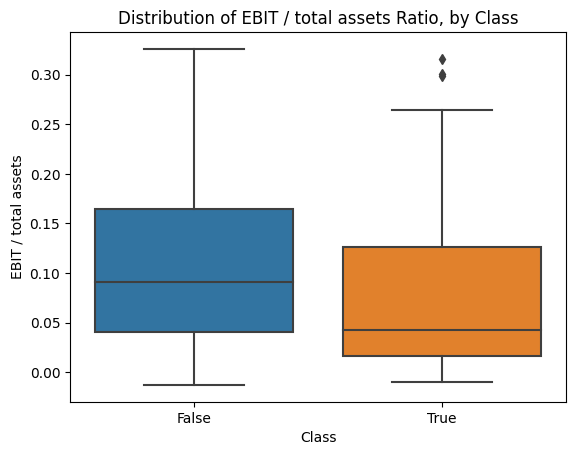

In [49]:
# Create clipped boxplot
q1, q9 = df["Attr7"].quantile([0.1, 0.9])
mask = df["Attr7"].between(q1, q9)
sns.boxplot(x="class", y="Attr7", data=df[mask])
plt.xlabel("Class")
plt.ylabel("EBIT / total assets")
plt.title("Distribution of EBIT / total assets Ratio, by Class");

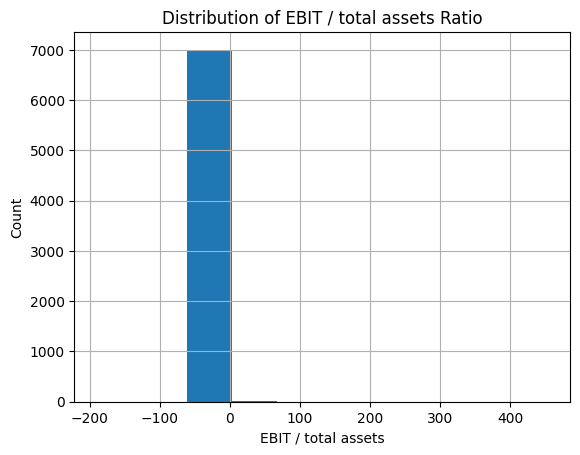

In [50]:
df["Attr7"].hist()
plt.xlabel("EBIT / total assets")
plt.ylabel("Count"),
plt.title("Distribution of EBIT / total assets Ratio");

***Multicollinearity Check:*** Correlation Heatmap

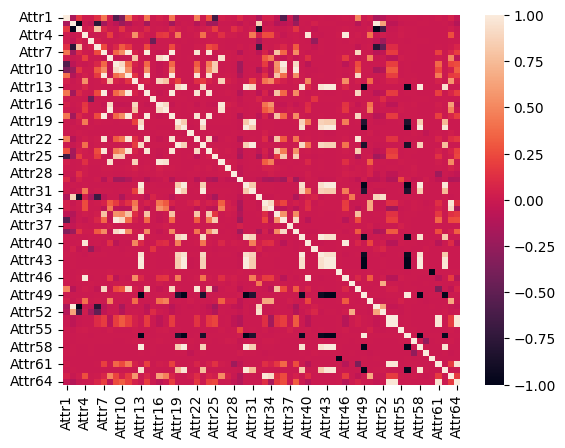

In [51]:
corr = df.drop(columns="class").corr()
sns.heatmap(corr);

EDA:

*   First, our data is imbalanced. This is something we need to address in our data preparation.
*   Second, many of our features have missing values that we'll need to impute. And since the features are highly skewed, the best imputation strategy is likely median, not mean.
*   Finally, we have autocorrelation issues, which means that we should steer clear of linear models, and try a tree-based model instead.

###1.3- Split Data


In [52]:
target = "class"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (7027, 64)
y shape: (7027,)


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5621, 64)
y_train shape: (5621,)
X_test shape: (1406, 64)
y_test shape: (1406,)


***Resample***

 ***Under-sampling***

In [54]:
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print(X_train_under.shape)
X_train_under.head()

(440, 64)


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
0,0.083801,0.69137,-0.12093,0.71466,-37.7370,0.000000,0.15832,0.44641,3.8944,0.30863,...,-219.26,0.061055,0.27152,0.96160,0.851650,20.8730,179.7600,39.720,9.1893,5.5864
1,0.475390,0.40938,0.54733,2.37410,302.8700,-0.012545,0.58823,1.44270,1.1372,0.59062,...,6707.90,0.460370,0.80491,0.51249,0.000000,29.9560,9.9641,127.850,2.8549,20.9260
2,0.173240,0.29784,0.30042,2.35970,30.7480,0.292910,0.21601,2.35750,1.1938,0.70216,...,5752.10,0.162350,0.24673,0.83765,0.109510,6.4705,4.6051,62.415,5.8480,2.6996
3,0.112740,0.52959,0.17520,2.10640,67.9310,0.000000,0.11274,0.88824,1.0380,0.47041,...,1673.90,0.247870,0.23966,0.76232,0.757990,43.6840,5.5789,55.683,6.5550,1.5576
4,0.346030,0.39724,0.37842,1.96130,6.3365,0.000000,0.43177,1.51740,3.7657,0.60276,...,1589.00,0.125540,0.57408,0.88544,0.005927,12.8870,9.8517,38.157,9.5656,16.5050


In [55]:
y_train_under.value_counts(normalize=True)

False    0.5
True     0.5
Name: class, dtype: float64

 ***Over-sampling***

In [56]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)
X_train_over.head()

(10802, 64)


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
0,0.535540,0.052232,0.441390,10.49400,165.210000,0.000000,0.535540,18.14500,1.81560,0.94777,...,27537.0,0.536310,0.565050,0.48781,0.000000,25.4630,4.6517,9.3465,39.0520,3.5452
1,0.000681,0.486750,-0.017475,0.94759,-5.587200,0.032626,0.000681,0.45175,0.99660,0.21989,...,-262.9,-0.003411,0.003096,1.00340,0.697370,106.4600,13.3880,35.6920,10.2260,4.9842
2,0.081678,0.422160,0.456520,2.70710,-0.063859,0.000000,0.101790,1.36880,1.97560,0.57784,...,2266.8,0.044539,0.141350,0.94900,0.000000,4.3322,9.3488,49.4080,7.3874,7.1565
3,0.172720,0.159200,0.627720,5.13760,16.825000,0.000000,0.172720,5.28150,1.93310,0.84080,...,1421.6,0.097010,0.205430,0.91067,0.008902,3.5406,9.2799,28.6460,12.7420,8.7645
4,0.070920,0.826400,-0.091116,0.71330,-85.703000,0.000000,0.070920,0.21007,0.79853,0.17360,...,-3796.8,0.102350,0.408520,0.91186,1.896600,11.1470,6.0414,145.2700,2.5126,1.0326


In [57]:
y_train_over.value_counts(normalize=True)

False    0.5
True     0.5
Name: class, dtype: float64

##2- Build Model

###2.1 Baseline

In [59]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9609


###2.2 Decision Tree Classifier

In [60]:
# Fit on `X_train`, `y_train`
model_reg = make_pipeline(
    SimpleImputer(strategy="median"),
    DecisionTreeClassifier(random_state=42)
)
model_reg.fit(X_train, y_train)

# Fit on `X_train_under`, `y_train_under`
model_under = make_pipeline(
    SimpleImputer(strategy="median"),
    DecisionTreeClassifier(random_state=42)
)
model_under.fit(X_train_under, y_train_under)

# Fit on `X_train_over`, `y_train_over`
model_over = make_pipeline(
    SimpleImputer(strategy="median"),
    DecisionTreeClassifier(random_state=42)
)
model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

###2.3 Evaluate: Accuracy Score


In [65]:
models = {'model_reg': model_reg, 'model_under': model_under, 'model_over': model_over}

for m_name, m in models.items():
    acc_train = m.score(X_train, y_train)
    acc_test = m.score(X_test, y_test)

    print(f"{m_name} - Training Accuracy: {round(acc_train, 4)}")
    print(f"{m_name} - Test Accuracy: {round(acc_test, 4)}")
    if acc_test > acc_baseline:
        print(f"{m_name} has a higher test accuracy than the baseline.")
    else:
        print(f"{m_name} does not have a higher test accuracy than the baseline.")
    print("------------------------------------")

model_reg - Training Accuracy: 1.0
model_reg - Test Accuracy: 0.9573
model_reg does not have a higher test accuracy than the baseline.
------------------------------------
model_under - Training Accuracy: 0.8098
model_under - Test Accuracy: 0.7845
model_under does not have a higher test accuracy than the baseline.
------------------------------------
model_over - Training Accuracy: 1.0
model_over - Test Accuracy: 0.9701
model_over has a higher test accuracy than the baseline.
------------------------------------


The model with oversampling passes the baseline

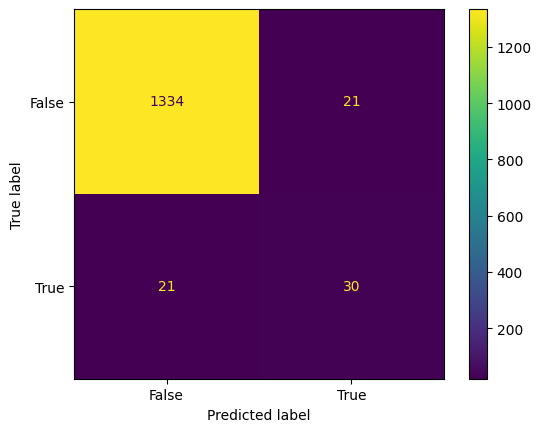

In [66]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_over, X_test, y_test);

In [67]:
depth = model_over.named_steps["decisiontreeclassifier"].get_depth()
print(depth)

28


##3- Communicate Results

The 15 most important features for model_over

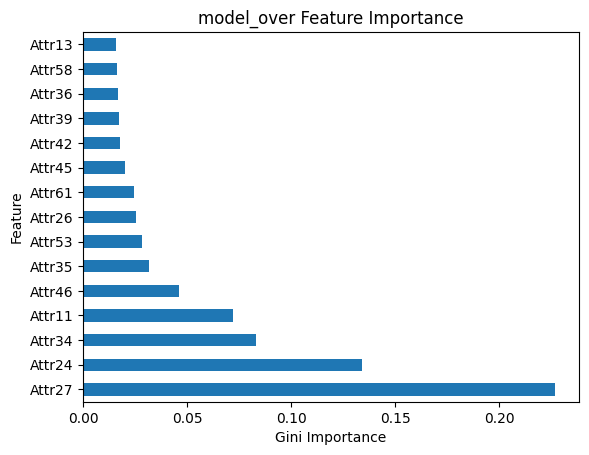

In [69]:
# Get importances
importances = model_over.named_steps["decisiontreeclassifier"].feature_importances_

# Put importances into a Series
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

# Plot series
feat_imp.head(15).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("model_over Feature Importance");

Save the best-performing model

In [70]:
with open("model_over-Polish-companies-1year.pkl", "wb") as f:
    pickle.dump(model_over, f)